# Interpretable ML

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Interpretable models

An interpretable model is one whose decisions humans can understand. Some models such as linear models with a small number of variables, or decision trees with limited depth, are intrinsically interpretable. Others such as ensembles, high-dimensional support vector machines or neural networks are essentially *black boxes*. Interpretable ML studies how to make *black box* models comprehensible to humans, typically by showing how a few key features influence the machine prediction.

Interpretable ML can be *local* and tell us something about how a machine makes a prediction for a particular instance, or *global*. Recently, there has been much interest in model-agnostic interpretable ML that can provide interpretation for multiple ML families (e.g. trees, support vector machines and neural nets).

Reference:

[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)

## Intrinsically interpretable models

In [6]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

### Decision trees

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [8]:
dt_gini = DecisionTreeClassifier(max_depth=2, criterion='gini', random_state=0)

In [9]:
dt_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

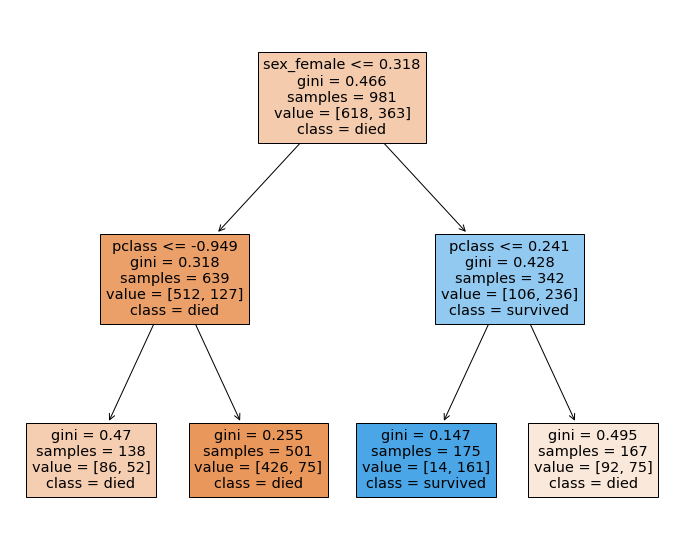

In [50]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
tree.plot_tree(dt_gini, 
               feature_names=X_train.columns,  
               class_names=['died', 'survived'],
               filled=True,
               ax = ax);

#### Gini coefficient

$$
1 - \sum{p_i^2}
$$

In [12]:
n1 = np.array([618, 363])
p1 = n1 / n1.sum()

In [13]:
gini = 1 - (p1**2).sum()
gini

0.4662159002702728

The Gini coefficient can be thought of as the degree of *impurity* - for two classes, we can see that the Gini coefficient reaches its maximum when both classes are equally represented.

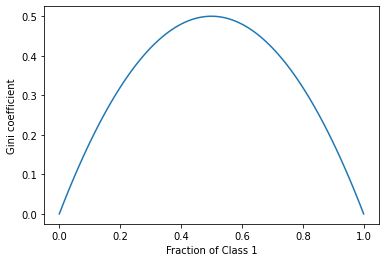

In [14]:
p = np.linspace(0, 1, 101)
ps = np.array([p, 1-p])
plt.plot(p, 1 - (ps**2).sum(axis=0))
plt.xlabel('Fraction of Class 1')
plt.ylabel('Gini coefficient');

#### Entropy or Information Gain

$$
- \sum{p_i \log(p_i)}
$$

In [15]:
dt_gain = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=0)

In [16]:
dt_gain.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)

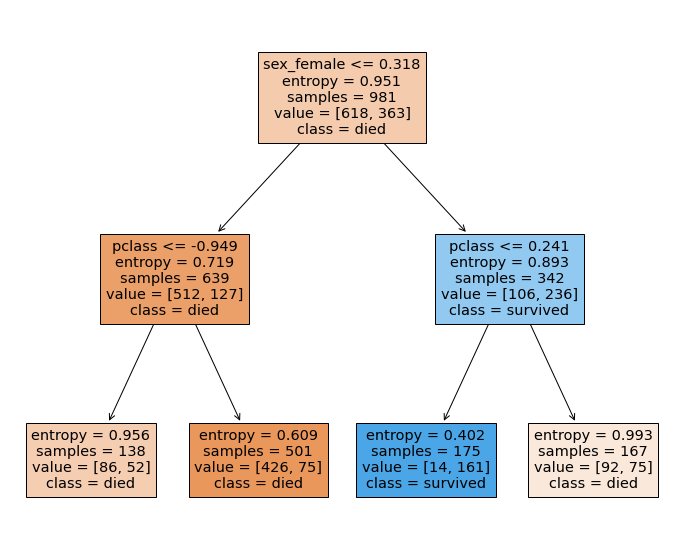

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
tree.plot_tree(dt_gain, 
               feature_names=X_train.columns,  
               class_names=['died', 'survived'],
               filled=True,
               ax = ax);

In [18]:
entropy = -(np.log2(p1) * p1).sum()

In [19]:
entropy

0.9506955707275353

The entropy can be thought of as a measure of *surprise* - it behaves quite similalriy to the Gini coefficinet.

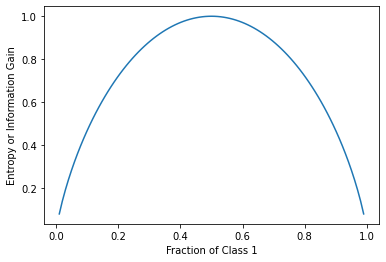

In [21]:
p = np.linspace(0.01, 0.99, 101)
ps = np.array([p, 1-p])
plt.plot(p, -np.sum(np.log2(ps)*ps, axis=0))
plt.xlabel('Fraction of Class 1')
plt.ylabel('Entropy or Information Gain');

### Linear models 

#### Logistic regression

For logistic regression, the log odds is a linear model

$$
\log\left(\frac{P(y = 1)}{1 - P(y=1)}\right) = \beta + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_k x_k
$$

So if we can think in terms of log odds as outcomes, then the contribution of a feature to the outcome is simply the feature coefficient multiplied by the value of the feature. This does not depend on how the feature is scaled, though of course the coefficients will be affected by scaling. 

In [22]:
from sklearn.linear_model import LogisticRegression

We set C to be a large value to minimize regularization

In [23]:
lr = LogisticRegression(C=1e6)

Since we are running vanilla logistic regression, we will remove collinear columns

In [24]:
X_train_ = X_train.drop(columns=['sex_male', 'embarked_'])
X_test_ = X_test.drop(columns=['sex_male', 'embarked_'])

In [25]:
lr.fit(X_train_, y_train)

LogisticRegression(C=1000000.0)

In [26]:
x0 = X_test_.iloc[0:1,:]

In [27]:
p = lr.predict_proba(x0)[0]

In [28]:
p

array([0.32298413, 0.67701587])

In [29]:
lr.coef_

array([[-0.94130541,  1.1544841 , -0.53540898, -0.42239517, -0.01071746,
         0.03766308, -4.10792748, -4.89538552, -3.10246539]])

In [30]:
β0 = lr.intercept_

In [31]:
β = lr.coef_

In [32]:
print(f'{(β0 + x0 @ β.T)[0][0]:.4f}')

0.7401


In [33]:
print(f'{(np.log(p[1]/p[0])):.4f}')

0.7401


In [34]:
import seaborn as sns

In [35]:
importance = (x0 * β).T

In [36]:
importance.sort_values(0, ascending=False, key=lambda x: np.abs(x))

,0
embarked_S,-3.249181
embarked_C,2.130908
sex_female,1.578067
embarked_Q,0.992048
pclass,-0.786542
age,0.602954
sibsp,0.194085
fare,-0.018147
parch,0.004692


### Surrogate models

One simple approach is to use an interpretable model to help interpret a black box model. This is done by replacing the target with the prediction of the black box model when training the interpretable model.

In this example, we use a shallow decision tree to interpret a Support Vector Classifier.

In [37]:
from sklearn.svm import SVC

In [38]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_train)

In [42]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_pred)

DecisionTreeClassifier(max_depth=2)

In [45]:
dt.score(X_train, y_pred)

0.9153924566768603

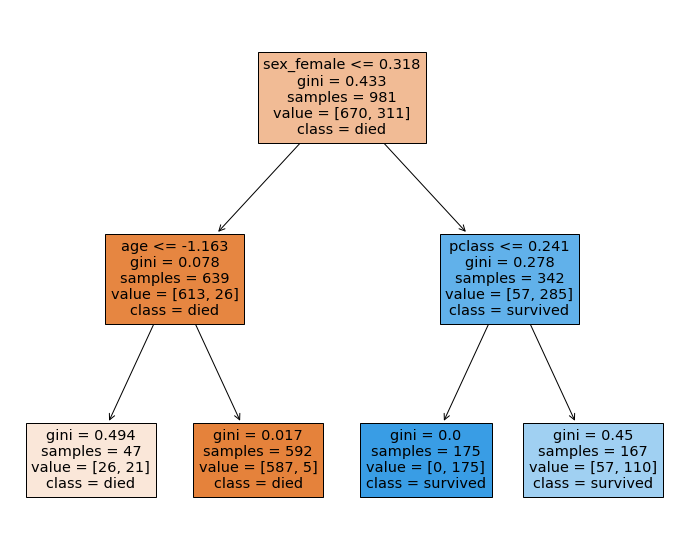

In [47]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
tree.plot_tree(dt, 
               feature_names=X_train.columns,  
               class_names=['died', 'survived'],
               filled=True,
               ax = ax);

## Model Agnostic Methods

### Partial dependence plot

Partial dependence plots show the dependence between the objective function and selected features, marginalizing over the values of all other features.

In [51]:
from sklearn.inspection import plot_partial_dependence

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [62]:
list(zip(range(12), X_train.columns))

[(0, 'pclass'),
 (1, 'sex_male'),
 (2, 'sex_female'),
 (3, 'age'),
 (4, 'sibsp'),
 (5, 'parch'),
 (6, 'fare'),
 (7, 'embarked_C'),
 (8, 'embarked_S'),
 (9, 'embarked_Q'),
 (10, 'embarked_')]

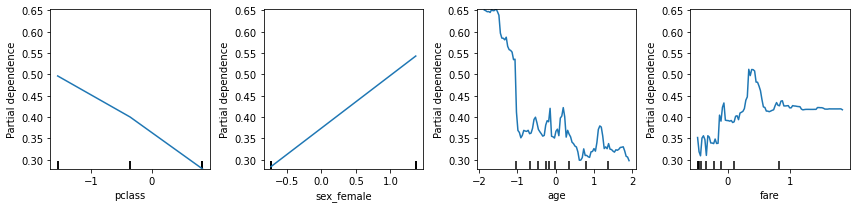

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
plot_partial_dependence(rf, X_train, [0,2,3,6, ], ax=ax)
plt.tight_layout()

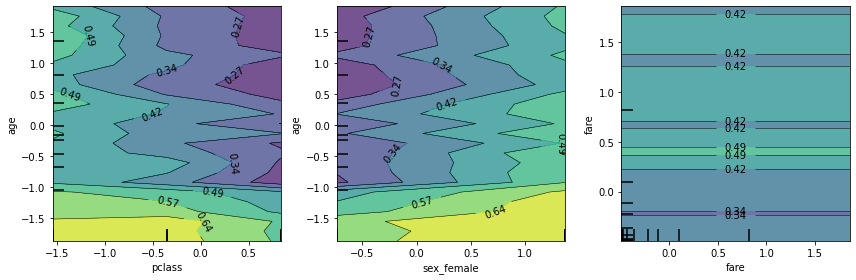

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plot_partial_dependence(rf, X_train, [(0,3), (2,3), (6,6)], 
                        grid_resolution=25, ax=ax)
plt.tight_layout()

### Permutation importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.

In [77]:
from sklearn.inspection import permutation_importance

In [78]:
r = permutation_importance(rf, 
                           X_test, 
                           y_test,
                           n_repeats=30,
                           random_state=0)

In [84]:
(
    pd.DataFrame(zip(X_test.columns, r.importances_mean), 
             columns=['Feature', 'Permutation Importance']).
    sort_values('Permutation Importance', key=lambda x: -np.abs(x))
)

,Feature,Permutation Importance
2,sex_female,0.127033
1,sex_male,0.054980
0,pclass,0.049492
3,age,0.039837
8,embarked_S,-0.011179
7,embarked_C,-0.009248
9,embarked_Q,-0.009248
6,fare,0.005081
4,sibsp,-0.002744
5,parch,-0.002337


#### Impurity-based importances

See [here](https://scikit-learn.org/stable/modules/permutation_importance.html#relation-to-impurity-based-importance-in-trees) for discussion of differences, and why permutation based importance is preferable.

In [86]:
(
    pd.DataFrame(zip(X_test.columns, rf.feature_importances_), 
             columns=['Feature', 'Permutation Importance']).
    sort_values('Permutation Importance', key=lambda x: -np.abs(x))
)

,Feature,Permutation Importance
3,age,0.296380
6,fare,0.260428
2,sex_female,0.140575
1,sex_male,0.092056
0,pclass,0.084108
4,sibsp,0.047764
5,parch,0.043629
7,embarked_C,0.018407
8,embarked_S,0.010869
9,embarked_Q,0.005739


### SHAP